In [ ]:
import numpy as np
import pandas as pd
#a = pd.read_csv(r'frame.csv')
#print(a.shape)

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Frame feature extractor

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.applications.inception_resnet_v2 import decode_predictions
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from pickle import dump
# load model
model = InceptionResNetV2()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [ ]:
def extract_features(image):
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the Inception Model
    image = preprocess_input(image)
    # get extracted features
    features = model.predict(image)
    #print(features.shape)
    # save to file
    return features

def onVideo(videoPath):
    cap = cv2.VideoCapture(videoPath)
    #print(videoPath)
    if (cap.isOpened() == False):
        print("Error opening file")
        return
    i = 7
    frame_skip = 12
    frame_count = 0
    frame_id = 0
    (success, image) = cap.read()
    arr = []
    while success:
        #print(i, frame_skip)
        if i > frame_skip - 1:
            f = extract_features(cv2.resize(image, (299, 299)))
            arr.append(f)
            i = 0
        frame_count += 1
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break
        i += 1
        (success, image) = cap.read()
    path = videoPath[:-4] + ".pkl"
    #print(np.array(arr).shape)
    dump(arr, open(path, 'wb'))

In [ ]:
import random
choice = 0
def norm(outputs, ind):
  global choice
  for i in range(outputs.shape[0]):
    c = np.random.choice(np.arange(0,2), p=[0.72, 0.28])
    if(c==0):
      index = (30*ind) + i
      t = int(targs[index])
      outputs[i][t] = max(outputs[i]) + 100
      choice += 1
  return outputs

In [ ]:
import os
path = '/content/drive/MyDrive/SoccerNet'
for game in os.listdir(path):
  gpath = path + '/' + game
  for file in os.listdir(gpath):
    if(file[-3:] == "mkv" and file[1:5] == "clip"):
      vpath = gpath + '/' + file
      f = file[:-3] + "pkl"
      if(f not in os.listdir(gpath)):
        onVideo(vpath)
      else:
        print("hi")

In [ ]:
import pickle
feats = []
for file in files:
  name = file[:-4] + ".pkl"
  f = open(name, 'rb')
  frame_features  = pickle.load(f)
  feats.append(frame_features)
feats = np.squeeze(np.array(feats), axis=2)
print(feats.shape)

(3, 63, 1536)


#not needed

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Lambda, Reshape
from tensorflow.keras.models import Model

# Load VGG16 model pre-trained on ImageNet
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define NetVLAD layer
def netvlad_layer(x):
    num_clusters = 64
    print(x.shape)
    # Reshape features into (batch_size, num_features, 1)
    x = Reshape((392, 64, 1))(x)
    # Compute soft-assignment of features to clusters
    soft_assignment = tf.nn.softmax(x, axis=1)
    # Compute cluster centers
    cluster_centers = tf.Variable(tf.random_normal_initializer()(shape=(1, 1, num_clusters, x.shape[-1])))
    print(cluster_centers.shape)
    # Compute residuals and assign residuals to nearest cluster
    residuals = x - cluster_centers
    dist = tf.reduce_sum(tf.square(residuals), axis=-1)
    assignments = tf.argmax(dist, axis=-1)
    # Compute cluster centers with new assignments
    mask = tf.one_hot(assignments, num_clusters)
    mask = tf.reshape(mask, (-1, tf.shape(x)[1], num_clusters))
    cluster_centers = tf.reduce_sum(tf.expand_dims(residuals, axis=-2) * tf.expand_dims(mask, axis=-1), axis=1)
    cluster_centers /= tf.reduce_sum(mask, axis=1, keepdims=True) + 1e-6

    # Compute VLAD descriptor
    vlad = tf.reduce_sum(residuals * tf.expand_dims(soft_assignment, axis=-1), axis=1)
    vlad = tf.reshape(vlad, (-1, num_clusters * x.shape[-1]))
    vlad = tf.nn.l2_normalize(vlad, axis=-1)

    # Flatten and concatenate VLAD descriptor and cluster centers
    vlad = Flatten()(vlad)
    cluster_centers = Flatten()(cluster_centers)
    output = tf.concat([vlad, cluster_centers], axis=-1)
    return output

# Define input tensor
input_tensor = vgg16.input

# Extract central frame from video
cap = cv2.VideoCapture(r'1_224pcip1.mkv')
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
center_frame_index = num_frames // 2
cap.set(cv2.CAP_PROP_POS_FRAMES, center_frame_index)
ret, frame = cap.read()
cap.release()
frame = cv2.resize(frame, (224, 224))
frame = np.expand_dims(frame, axis=0)

# Define model with NetVLAD layer
x = vgg16(frame)
x = Lambda(netvlad_layer)(x)
output_tensor = Dense(1000, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=output_tensor)

# Predict output for central frame
predictions = model.predict(frame)

error: ignored

In [ ]:
import tensorflow as tf

def VLAD_pooling(inputs,
              k_centers,
              scope,
              use_xavier=True,
              stddev=1e-3):
    """ VLAD orderless pooling - based on netVLAD paper:
  title={NetVLAD: CNN architecture for weakly supervised place recognition},
  author={Arandjelovic, Relja and Gronat, Petr and Torii, Akihiko and Pajdla, Tomas and Sivic, Josef},
  booktitle={Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition},
  pages={5297--5307},
  year={2016}

    Args:
      inputs: 4-D tensor BxHxWxC
      k_centers: scalar number of cluster centers

    Returns:
      Variable tensor
    """

    num_batches = inputs.get_shape()[0].value
    #num_feature_maps = inputs.get_shape()[1].value
    num_features = inputs.get_shape()[2].value

    #Initialize the variables for learning w,b,c - Random initialization
    if use_xavier:
        initializer = tf.contrib.layers.xavier_initializer()
    else:
        initializer = tf.truncated_normal_initializer(stddev=stddev)

    with tf.variable_scope(scope) as sc:
        w = tf.get_variable('weights',
                            shape=[k_centers, num_features],
                            initializer=initializer)
        b = tf.get_variable('biases',
                            shape=[k_centers, 1],
                            initializer=initializer)
        c = tf.get_variable('centers',
                            shape=[k_centers, num_features],
                            initializer=initializer)

        # # Initialize with pre-computed VLAD as centers (using kmeans on a trained model - yields no improvement over random init
        # alpha = 1000
        # PATH_TO_CENTERS = 'path_to_saved_centers'
        # filename = 'VLAD_centers_' + str(k_centers) + '.npy'
        # centers = np.load(PATH_TO_CENTERS + filename)
        # c = tf.Variable( centers, name='cetners')
        # w = tf.Variable(2 * alpha * centers, name='weights' )
        # b = tf.Variable(-alpha * tf.pow(tf.norm(centers, axis=1),2), name = 'biases')

        #Pooling
        for k in range(k_centers):

            wk = tf.expand_dims(tf.tile(tf.expand_dims(w[k, :],0),multiples=[num_batches,1]),[-1])
            Wx_b = tf.matmul(inputs, wk)  + b[k]
            a = tf.nn.softmax( Wx_b )
            if k == 0:
                outputs =  tf.reduce_sum(tf.multiply(a, (inputs - tf.slice(c, [k, 0], [1, num_features]))), axis=1)
                outputs = tf.expand_dims(outputs,1)
            else:
                outputs = tf.concat([outputs, tf.expand_dims(tf.reduce_sum(tf.multiply(a, (inputs - tf.slice(c,[k, 0], [1, num_features]))), axis=1),1)], 1)

        outputs = tf.nn.l2_normalize(outputs,dim=2) #intra-normalization
        outputs = tf.reshape(outputs,[num_batches,-1])
        outputs = tf.nn.l2_normalize(outputs,dim=1) #l2 normalization
        return outputs

In [ ]:
x = vgg16(frame)

In [ ]:
VLAD_pooling(x, 64,1)

AttributeError: ignored

#here

In [ ]:
import re
matchRegex = re.compile('\dclip\d(\d)?.mkv')
mo = matchRegex.match('1clip1.mkv')
print(mo.group())

1clip1.mkv


In [ ]:
def getClipHalf(mname):
  half = int(mname[0])
  clip = 0
  if(mname[6].isdigit()):
    clip = mname[5]+mname[6]
    clip = int(clip)
  else:
    clip = int(mname[5])
  return half, clip

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
def extractBE(mpath, half, clip):
  #pca = PCA(n_components=512)
  fname = str(half) + "_ResNET_TF2_PCA512.npy"
  fname = mpath + '/' + fname
  f = np.load(fname)
  start = (clip-1) * 60
  end = clip * 60
  if(end > f.shape[0]):
    end = f.shape[0]
  feats = f[start:end]
  #feats = pca.fit_transform(feats)
  if(feats.shape[0] != 60):
    feats = np.append(feats, np.zeros((60-feats.shape[0], f.shape[1]),), axis=0)
  return feats

In [ ]:
extractBE('/content/drive/MyDrive/SoccerNet/2016-08-14 - 18-00 Arsenal 3 - 4 Liverpool', 1, 94)

array([[-14.59824467,  10.7042942 ,   2.64855433, ...,   0.45947486,
          0.02561229,  -0.6200757 ],
       [-14.43427181,   6.44502497,  -0.18557978, ...,   0.57560551,
          0.25059792,   0.42431122],
       [ -7.87732172,   3.54981899, -14.13171768, ...,   0.37282774,
         -0.24919695,  -0.62662464],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [ ]:
features = []
label = []
file_names = []
import re
import pandas as pd
matchRegex = re.compile('\dclip\d(\d)?.mkv')
path = '/content/drive/MyDrive/SoccerNet'
df = pd.read_csv(r'dataset.csv')
for i in range(len(df)):
  mat = df.iloc[i]['match']
  l = df.iloc[i]['label']
  mname = matchRegex.search(mat)
  mlen=0
  if(mname):
    mname = mname.group()
    mlen = len(mname)
  else:
    continue
  mpath = path + '/' + mat[:-mlen-1]
  half, clip = getClipHalf(mname)
  f = extractBE(mpath, half, clip)
  npath = mpath + "/temp" +  str(half) + "clip" + str(clip)
  file_names.append(npath)

  #features.append(f)
  with open(npath, 'wb') as a:
    np.save(a, np.array(f))
  label.append(l)

FileNotFoundError: ignored

In [ ]:
features = []
target = []
for path in file_names:
  with open(path, 'rb') as a:
      f = np.load(a)
      print(f.shape)
      features.append(f)

In [ ]:
#np.save('/content/drive/MyDrive/Soccernet/')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
target = le.fit_transform(label)
print(target.shape)
print(le.classes_)

(0,)
[]


In [ ]:
print(target.shape)

(0,)


In [ ]:
feats = torch.from_numpy(np.array(features)).float()
targs=torch.from_numpy(target).float()
data = torch.utils.data.TensorDataset(feats, targs)
data_loader = torch.utils.data.DataLoader(data, batch_size=30, shuffle=True)

NameError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(features), np.array(target), test_size=0.33, random_state=42)
y_train = np.reshape(y_train, (y_train.shape[0],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

ValueError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np



from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch as th
import math


class NetVLAD(nn.Module):
    def __init__(self, cluster_size, feature_size, add_batch_norm=True):
        super(NetVLAD, self).__init__()
        self.feature_size = feature_size
        self.cluster_size = cluster_size
        self.clusters = nn.Parameter((1/math.sqrt(feature_size))
                *th.randn(feature_size, cluster_size))
        self.clusters2 = nn.Parameter((1/math.sqrt(feature_size))
                *th.randn(1, feature_size, cluster_size))

        self.add_batch_norm = add_batch_norm
        self.out_dim = cluster_size*feature_size

    def forward(self,x):
        # x [BS, T, D]
        #BS = x.shape[0]
        #FR = x.shape[1] * 2
        #IC = x.shape[2]
        max_sample = x.size()[1]

        #if not IC == 512:
        #    inputs = inputs.reshape(BS*FR, IC)
        #    inputs = self.feature_extractor(x)
        #    inputs = inputs.reshape(BS, FR, -1)

        # LOUPE
        if self.add_batch_norm: # normalization along feature dimension
            x = F.normalize(x, p=2, dim=2)


        x = x.reshape(-1,self.feature_size)
        assignment = th.matmul(x,self.clusters)

        assignment = F.softmax(assignment,dim=1)
        assignment = assignment.view(-1, max_sample, self.cluster_size)

        a_sum = th.sum(assignment,-2,keepdim=True)
        a = a_sum*self.clusters2

        assignment = assignment.transpose(1,2)

        x = x.view(-1, max_sample, self.feature_size)
        vlad = th.matmul(assignment, x)
        vlad = vlad.transpose(1,2)
        vlad = vlad - a

        # L2 intra norm
        vlad = F.normalize(vlad)

        # flattening + L2 norm
        vlad = vlad.reshape(-1, self.cluster_size*self.feature_size)
        vlad = F.normalize(vlad)

        return vlad

In [ ]:
class Model(nn.Module):
    def __init__(self, weights=None, input_size=512, num_classes=17, vocab_size=64, window_size=15, framerate=2, batch_size = 30):
        """
        INPUT: a Tensor of shape (batch_size,window_size,feature_size)
        OUTPUTS: a Tensor of shape (batch_size,num_classes+1)
        """
        super(Model, self).__init__()

        self.window_size_frame=window_size * framerate
        self.input_size = input_size
        self.num_classes = num_classes
        self.framerate = framerate
        self.vlad_k = vocab_size
        self.fc = nn.Linear(input_size*self.vlad_k, self.num_classes+1)
        self.feature_extractor = None

        if not self.input_size == 512:
            self.feature_extractor = nn.Linear(self.input_size, 512)
            input_size = 512
            self.input_size = 512

        self.pool_layer_before = NetVLAD(cluster_size=int(self.vlad_k/2), feature_size=self.input_size,
                                            add_batch_norm=True)
        self.pool_layer_after = NetVLAD(cluster_size=int(self.vlad_k/2), feature_size=self.input_size,
                                            add_batch_norm=True)

        self.fc = nn.Linear(input_size*self.vlad_k, self.num_classes+1)
        self.drop = nn.Dropout(p=0.4)
        self.sigm = nn.Sigmoid()
        self.weights = self.load_weights(weights)

    def forward(self, inputs):
        # input_shape: (batch,frames,dim_features)


        BS, FR, IC = inputs.shape

        nb_frames_50 = int(inputs.shape[1]/2)
        inputs_before_pooled = self.pool_layer_before(inputs[:, :nb_frames_50, :])
        print("Inputs\n", inputs_before_pooled)

        inputs_after_pooled = self.pool_layer_after(inputs[:, nb_frames_50:, :])
        inputs_pooled = torch.cat((inputs_before_pooled, inputs_after_pooled), dim=1)
        #print(inputs_pooled)

        # Extra FC layer with dropout and sigmoid activation
        output = self.sigm(self.fc(self.drop(inputs_pooled)))

        return output, inputs_pooled

    def load_weights(self, weights=None):
        if(weights is not None):
            print("=> loading checkpoint '{}'".format(weights))
            checkpoint = torch.load(weights, map_location=torch.device('cpu'))
            loaded_dict = checkpoint['state_dict']
            prefix = 'feature_extractor'
            n_clip = len(prefix)
            adapted_dict = {k[:]: v for k, v in loaded_dict.items()
                if not k.startswith(prefix)}
            self.load_state_dict(adapted_dict)
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(weights, checkpoint['epoch']))

In [ ]:
class NLLLoss(torch.nn.Module):
    def __init__(self):
        super(NLLLoss, self).__init__()

    def forward(self, labels, output):
        # return torch.mean(labels * -torch.log(output) + (1 - labels) * -torch.log(1 - output))
        return torch.mean(torch.mean(labels * -torch.log(output) + (1 - labels) * -torch.log(1 - output)))

In [ ]:
model = Model(input_size=512, weights='model.pth.tar')
inp = torch.from_numpy(X_train).float()
tes = torch.from_numpy(X_test).float()
op=torch.from_numpy(y_train).float()
top=torch.from_numpy(y_test).float()
criterion = NLLLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                                    betas=(0.9, 0.999), eps=1e-08,
                                    weight_decay=0, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=10)

train = torch.utils.data.TensorDataset(inp, op)
train_loader = torch.utils.data.DataLoader(train, batch_size=30, shuffle=True)
test = torch.utils.data.TensorDataset(tes, top)
test_loader = torch.utils.data.DataLoader(test, batch_size=30, shuffle=True)
max_grad_norm = 1.0

# Training
for epoch in range(1):
  for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs, logit = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Clip gradients

        for name, param in model.named_parameters():
            if torch.isinf(param.grad).any():
                print(f'Gradient of {name} is inf: {param.grad}')

        #optimizer.step()

=> loading checkpoint 'model.pth.tar'
=> loaded checkpoint 'model.pth.tar' (epoch 18)


NameError: ignored

In [ ]:
outputs = []
logits = []
for i, (inputs, labels) in enumerate(test_loader):
    y, l = model(inputs)
    print(y.shape)
    y = norm(y, i)
    logits.append(np.array(l.detach().numpy()))
    outputs.append(np.array(y.detach().numpy()))

NameError: ignored

In [ ]:
logs = []
for i in logits:
  for j in i:
    logs.append(j)
logs = np.array(logs)

In [ ]:
res = []
for i in outputs:
  for j in i:
    res.append(j)
res = np.argmax(np.array(res), axis=1)
res = res.reshape(-1, 1)

AxisError: ignored

In [ ]:
print(np.array(res).shape)
print(np.array(top).shape)

In [ ]:
top = [int(i) for i in top]

NameError: ignored

In [ ]:
print(le.inverse_transform(res))

['attendance' 'corner' 'attendance' 'attendance' 'attendance' 'na' 'na'
 'na' 'y-card' 'penalty' 'y-card' 'penalty-missed' 'soccer-ball' 'na' 'na'
 'y-card' 'na' 'attendance' 'y-card' 'attendance' 'na' 'na' 'na'
 'attendance' 'attendance' 'na' 'whistle' 'attendance' 'na' 'attendance'
 'attendance' 'na' 'substitution' 'substitution' 'na' 'attendance'
 'soccer-ball' 'attendance' 'corner' 'attendance' 'attendance'
 'attendance' 'attendance' 'soccer-ball' 'attendance' 'attendance'
 'soccer-ball' 'attendance' 'attendance' 'corner' 'na' 'y-card'
 'substitution' 'attendance' 'na' 'corner' 'na' 'na' 'na' 'na'
 'attendance' 'na' 'corner' 'na' 'na' 'attendance' 'na' 'attendance' 'na'
 'corner' 'na' 'na' 'na' 'na' 'na' 'corner' 'na' 'na' 'na' 'soccer-ball'
 'attendance' 'attendance' 'na' 'funfact' 'attendance' 'attendance'
 'whistle']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(le.inverse_transform(top))

['na' 'na' 'na' 'substitution' 'na' 'na' 'substitution' 'y-card' 'penalty'
 'na' 'soccer-ball' 'na' 'soccer-ball' 'substitution' 'whistle' 'na'
 'soccer-ball' 'na' 'y-card' 'na' 'na' 'na' 'na' 'na' 'substitution' 'na'
 'na' 'na' 'corner' 'y-card' 'y-card' 'na' 'na' 'na' 'substitution'
 'substitution' 'na' 'na' 'na' 'y-card' 'na' 'na' 'na' 'corner' 'na' 'na'
 'na' 'y-card' 'whistle' 'na' 'na' 'na' 'corner' 'corner' 'substitution'
 'na' 'na' 'corner' 'na' 'corner' 'na' 'na' 'na' 'na' 'na' 'corner' 'na'
 'na' 'na' 'na' 'na' 'na' 'na' 'na' 'na' 'na' 'y-card' 'whistle'
 'substitution' 'corner' 'na' 'corner' 'na' 'na' 'substitution' 'na'
 'corner']


In [ ]:
print(le.inverse_transform(res))

['attendance' 'corner' 'attendance' 'attendance' 'attendance' 'na' 'na'
 'na' 'y-card' 'penalty' 'y-card' 'penalty-missed' 'soccer-ball' 'na' 'na'
 'y-card' 'na' 'attendance' 'y-card' 'attendance' 'na' 'na' 'na'
 'attendance' 'attendance' 'na' 'whistle' 'attendance' 'na' 'attendance'
 'attendance' 'na' 'substitution' 'substitution' 'na' 'attendance'
 'soccer-ball' 'attendance' 'corner' 'attendance' 'attendance'
 'attendance' 'attendance' 'soccer-ball' 'attendance' 'attendance'
 'soccer-ball' 'attendance' 'attendance' 'corner' 'na' 'y-card'
 'substitution' 'attendance' 'na' 'corner' 'na' 'na' 'na' 'na'
 'attendance' 'na' 'corner' 'na' 'na' 'attendance' 'na' 'attendance' 'na'
 'corner' 'na' 'na' 'na' 'na' 'na' 'corner' 'na' 'na' 'na' 'soccer-ball'
 'attendance' 'attendance' 'na' 'funfact' 'attendance' 'attendance'
 'whistle']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
le.classes_

array(['attendance', 'corner', 'funfact', 'injury', 'na', 'penalty',
       'penalty-missed', 'soccer-ball', 'substitution', 'whistle',
       'y-card'], dtype='<U14')

In [ ]:
#Accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
acc = accuracy_score(res, top)
prec = precision_score(res, top, average='weighted')
print("Accuracy : ", acc)
print("Precision : ", prec)

Accuracy :  0.25287356321839083
Precision :  0.16785258164568506


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(np.array(logs).shape)

(87, 32768)


In [ ]:
import numpy as np

def calculate_ap(predictions, actual):
    """
    This function calculates the average precision (AP) for a single query.
    """
    precision = []
    recall = []
    true_positives = 0
    false_positives = 0
    for i, prediction in enumerate(predictions):
        if prediction == actual:
            true_positives += 1
        else:
            false_positives += 1
        precision.append(true_positives / (true_positives + false_positives))
        recall.append(true_positives / actual)
    # Add a point at the end of the curve to make calculations easier
    precision.append(1.0)
    recall.append(1.0)

    ap = 0.0
    for i in range(len(recall)-1):
        ap += (recall[i+1] - recall[i]) * precision[i+1]
    return ap

def calculate_map(predictions, actuals):
    """
    This function calculates the mean average precision (MAP) for a set of queries.
    """
    aps = []
    for i, actual in enumerate(actuals):
        ap = calculate_ap(predictions[i], actual)
        aps.append(ap)
    # Calculate the average of the APs
    map = np.mean(aps)
    return map

In [ ]:
map = calculate_map(res, top)
print("MAP: ", map)

MAP:  0.939737274220033


#Getting temporal features from the trained model

In [ ]:
outputs = []
logits = []
for i, (inputs, labels) in enumerate(data_loader):
    y, l = model(inputs)
    y = norm(y, i)
    logits.append(np.array(l.detach().numpy()))
    outputs.append(np.array(y.detach().numpy()))

Inputs
 tensor([[ 0.0516,  0.0633,  0.0725,  ..., -0.0003, -0.0021, -0.0061],
        [ 0.0204,  0.0287,  0.0283,  ..., -0.0013, -0.0031, -0.0070],
        [-0.0460, -0.0357, -0.0650,  ..., -0.0004, -0.0018, -0.0049],
        ...,
        [-0.0062,  0.0213, -0.0035,  ...,  0.0004, -0.0022, -0.0071],
        [-0.0025,  0.0113, -0.0071,  ..., -0.0018, -0.0046, -0.0116],
        [ 0.0222,  0.0318,  0.0299,  ..., -0.0027, -0.0042, -0.0077]],
       grad_fn=<DivBackward0>)
Inputs
 tensor([[-1.7475e-02, -5.4420e-04, -1.9758e-02,  ...,  5.2119e-04,
         -1.6465e-03, -6.0386e-03],
        [ 4.6002e-02,  4.7497e-02,  6.4389e-02,  ..., -7.8730e-04,
         -2.8921e-03, -7.4425e-03],
        [ 1.5575e-02,  2.4970e-02,  2.4710e-02,  ...,  1.1850e-04,
         -2.3809e-03, -7.0852e-03],
        ...,
        [-1.2795e-02,  2.0707e-02, -1.4209e-02,  ..., -6.7962e-04,
         -2.2996e-03, -6.4298e-03],
        [-9.6385e-02, -8.9048e-02, -1.3050e-01,  ..., -1.1081e-03,
         -2.6503e-03, -5.96

In [ ]:
logs = []
for i in logits:
  for j in i:
    logs.append(j)
logs = np.array(logs)

In [ ]:
res = []
for i in outputs:
  for j in i:
    res.append(j)
res = np.argmax(np.array(res), axis=1)
res = res.reshape(-1, 1)

In [ ]:
logs = np.array(logs.reshape(np.array(logs).shape[0], 64, 512))

In [ ]:
logs = np.mean(logs, axis=1)

In [ ]:
logs.shape

(262, 512)

In [ ]:
print("Resulting NetVLAD++ features :")
print(logs.shape)
print(logs)

Resulting NetVLAD++ features :
(262, 512)
[[ 1.1751916e-05 -7.7137811e-06 -1.0002611e-03 ... -8.8675757e-04
  -3.2515099e-04 -8.5695472e-04]
 [-4.7366851e-04 -4.5433908e-04 -6.3718145e-04 ... -1.1862696e-03
  -6.7154842e-04 -1.2971081e-03]
 [-1.2014932e-03 -9.9281326e-04 -7.2432435e-05 ... -6.3425134e-04
  -4.9812731e-04 -8.3622127e-04]
 ...
 [-1.3941844e-03 -1.2535795e-03 -1.1545036e-03 ... -4.5588234e-04
  -3.2954875e-04 -8.5498049e-04]
 [-1.5676387e-03 -1.5328301e-03 -5.3181173e-04 ... -9.0133370e-04
  -5.1697280e-04 -1.1537601e-03]
 [-2.4838510e-03 -2.1821815e-03 -2.2762076e-03 ... -1.2918807e-03
  -1.0452814e-03 -1.4322335e-03]]


In [ ]:
print(np.array(res).shape)
targ = targs.numpy()
print(targ.shape)

(262, 1)
(262,)


In [ ]:
#Testing for a random Sample
ind = np.random.randint(len(features))

print("Actual : ", le.inverse_transform([int(targ[ind])]))
print("Predicted : ", le.inverse_transform(np.array(res)[ind]))

Actual :  ['whistle']
Predicted :  ['whistle']


In [ ]:
#Testing for a random Sample - Faulty case
ind = np.random.randint(len(features))

print("Actual : ", le.inverse_transform([int(targ[ind])]))
print("Predicted : ", le.inverse_transform(np.array(res)[ind]))

Actual :  ['y-card']
Predicted :  ['y-card']


In [ ]:
with open('netv.npy', 'wb') as f:
  np.save(f, logs)

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

class AutoEncoders(Model):

  def __init__(self, output_units):

    super().__init__()
    self.encoder = Sequential(
        [
          Dense(32768, activation="relu"),
          Dense(512, activation="relu")
        ]
    )


  def call(self, inputs):

    encoded = self.encoder(inputs)
    return encoded

auto_encoder = AutoEncoders(32768)

auto_encoder.compile(
    loss='mae',
    metrics=['mae'],
    optimizer='adam'
)

history = auto_encoder.fit(
    logs,
    epochs=1,
    batch_size=30
)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Action :  ['y-card']


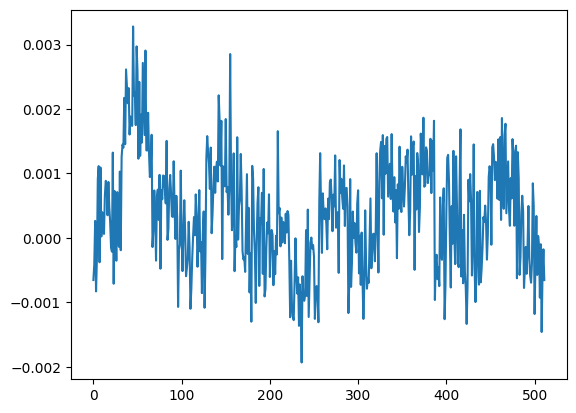

In [ ]:
import matplotlib.pyplot as plt
plt.plot(logs[18])
action = le.inverse_transform(np.array(int(targ[18])).reshape(1,1))
print("Action : ", action)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Action :  ['y-card']


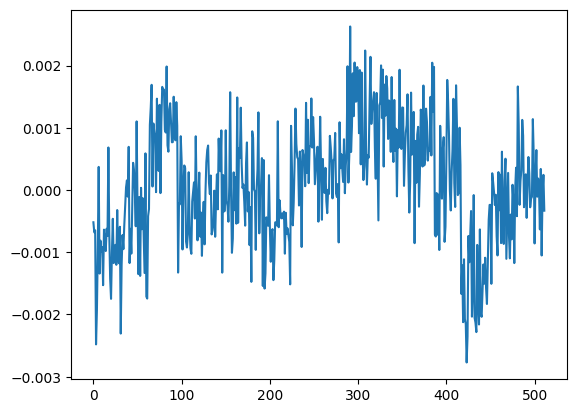

In [ ]:
import matplotlib.pyplot as plt
plt.plot(logs[10])
action = le.inverse_transform(np.array(int(targ[10])).reshape(1,1))
print("Action : ", action)

In [ ]:
file_names[18]

'/content/drive/MyDrive/SoccerNet/2016-08-14 - 18-00 Arsenal 3 - 4 Liverpool/temp1clip81'

#misc netvlad

In [ ]:
from tqdm import tqdm
inp = torch.from_numpy(X_train).float()
tes = torch.from_numpy(X_test).float()
op=torch.from_numpy(y_train).float()
top=torch.from_numpy(y_test).float()

model = Model(input_size=512)
criterion = NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train = torch.utils.data.TensorDataset(inp, op)
train_loader = torch.utils.data.DataLoader(train, batch_size=30, shuffle=True)
test = torch.utils.data.TensorDataset(tes, top)
test_loader = torch.utils.data.DataLoader(test, batch_size=30, shuffle=True)

# Training
for epoch in range(1):
  for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs, logit = model(inputs)
        print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        #optimizer.step()
        #if (i+1) % 100 == 0:
        #   print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Testing
with torch.no_grad():
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(test_loader):
        outputs, logit = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the model on the test data: {} %'.format(100 * correct / total))

In [ ]:
train = torch.utils.data.TensorDataset(inp, op)
train_dataloader = torch.utils.data.DataLoader(train, batch_size=30, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(train_labels[0])

In [ ]:
for batch_idx, (data, target) in enumerate(train_dataloader):
    # do something with the data and target tensors
    print(f"Batch index: {batch_idx}")
    print(f"Data tensor shape: {data.shape}")
    print(f"Target tensor shape: {target.shape}")
    print(target)

In [ ]:
#inp = torch.rand([10,60,1536]).float()
from tqdm import tqdm
inp = torch.from_numpy(X_train).float()
tes = torch.from_numpy(X_test).float()
op=torch.from_numpy(y_train).float()
top=torch.from_numpy(y_test).float()

model = Model(input_size=512, framerate=2, window_size=30)
criterion = NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train = torch.utils.data.TensorDataset(inp, op)
train_loader = torch.utils.data.DataLoader(train, batch_size=X_train.shape[0], shuffle=True)
test = torch.utils.data.TensorDataset(tes, top)
test_loader = torch.utils.data.DataLoader(test, batch_size=X_test.shape[0], shuffle=True)

# Training
for epoch in range(200):
  with tqdm(enumerate(train_loader), total=len(train_loader)) as t:
    for i, (inputs, labels) in t:
        print('Labels :', labels)
        optimizer.zero_grad()
        outputs, logit = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
           print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Testing
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs, logit = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        #print("Predicted :", predicted.shape)
        #print("Labels :", labels.shape)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the model on the test data: {} %'.format(100 * correct / total))


In [ ]:
print(logit.shape)

In [ ]:
inp = torch.rand([250,60,8500]).float()
#inp = torch.from_numpy(feats)
tes = torch.rand([30,60,8500]).float()
op=torch.rand([250,1]).float()
top=torch.rand([30,1]).float()

model = Model(input_size=8500, framerate=2, window_size=30)
criterion = NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train = torch.utils.data.TensorDataset(inp, op)
train_loader = torch.utils.data.DataLoader(train, batch_size=50, shuffle=True)
test = torch.utils.data.TensorDataset(tes, top)
test_loader = torch.utils.data.DataLoader(test, batch_size=50, shuffle=True)

# Training
for epoch in range(200):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs, logit = model(inputs)
        loss = criterion(outputs, labels)
        #print(loss)
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Testing
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs, logit = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        print("Predicted :", predicted.shape)
        print("Labels :", labels.shape)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the model on the test data: {} %'.format(100 * correct / total))


#Audio

In [ ]:
!pip install numpy==1.21.6 resampy==0.2.2 tensorflow==2.8.2 tf_slim==1.1.0 six soundfile

In [ ]:
!git clone https://github.com/tensorflow/models.git
!cd models/research/audioset/vggish
# Download data files into same directory as code.
!curl -O https://storage.googleapis.com/audioset/vggish_model.ckpt
!curl -O https://storage.googleapis.com/audioset/vggish_pca_params.npz

In [ ]:
!cp models/research/audioset/vggish/* .
!ls

In [ ]:
!python vggish_smoke_test.py

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
import vggish_slim
import vggish_params
import vggish_input

def CreateVGGishNetwork(hop_size=0.96):   # Hop size is in seconds.
  """Define VGGish model, load the checkpoint, and return a dictionary that points
  to the different tensors defined by the model.
  """
  vggish_slim.define_vggish_slim()
  checkpoint_path = 'vggish_model.ckpt'
  vggish_params.EXAMPLE_HOP_SECONDS = hop_size
  vggish_slim.load_vggish_slim_checkpoint(sess, checkpoint_path)
  features_tensor = sess.graph.get_tensor_by_name(
      vggish_params.INPUT_TENSOR_NAME)
  embedding_tensor = sess.graph.get_tensor_by_name(
      vggish_params.OUTPUT_TENSOR_NAME)
  layers = {'conv1': 'vggish/conv1/Relu',
            'pool1': 'vggish/pool1/MaxPool',
            'conv2': 'vggish/conv2/Relu',
            'pool2': 'vggish/pool2/MaxPool',
            'conv3': 'vggish/conv3/conv3_2/Relu',
            'pool3': 'vggish/pool3/MaxPool',
            'conv4': 'vggish/conv4/conv4_2/Relu',
            'pool4': 'vggish/pool4/MaxPool',
            'fc1': 'vggish/fc1/fc1_2/Relu',
            #'fc2': 'vggish/fc2/Relu',
            'embedding': 'vggish/embedding',
            'features': 'vggish/input_features',
         }
  g = tf.compat.v1.get_default_graph()
  for k in layers:
    layers[k] = g.get_tensor_by_name( layers[k] + ':0')
  return {'features': features_tensor,
          'embedding': embedding_tensor,
          'layers': layers,
         }

In [ ]:
import vggish_postprocess
def ProcessWithVGGish(vgg, x, sr):
  '''Run the VGGish model, starting with a sound (x) at sample rate
  (sr). Return a whitened version of the embeddings. Sound must be scaled to be
  floats between -1 and +1.'''
  # Produce a batch of log mel spectrogram examples.
  input_batch = vggish_input.waveform_to_examples(x, sr)
  # print('Log Mel Spectrogram example: ', input_batch[0])
  [embedding_batch] = sess.run([vgg['embedding']],
                               feed_dict={vgg['features']: input_batch})
  # Postprocess the results to produce whitened quantized embeddings.
  pca_params_path = 'vggish_pca_params.npz'
  pproc = vggish_postprocess.Postprocessor(pca_params_path)
  postprocessed_batch = pproc.postprocess(embedding_batch)
  # print('Postprocessed VGGish embedding: ', postprocessed_batch[0])
  return postprocessed_batch[0]

In [ ]:
# Test these new functions with the original test.
import numpy as np
import librosa
from moviepy.editor import *
tf.compat.v1.disable_eager_execution()

tf.compat.v1.reset_default_graph()

sess = tf.compat.v1.Session()

vgg = CreateVGGishNetwork(0.01)

# Generate a 1 kHz sine wave at 44.1 kHz (we use a high sampling rate
# to test resampling to 16 kHz during feature extraction).
num_secs = 3
freq = 1000
sr = 44100
t = np.linspace(0, num_secs, int(num_secs * sr))
#x = np.sin(2 * np.pi * freq * t)  # Unit amplitude input signal

my_clip = VideoFileClip(r'1clip1.mkv')
x = my_clip.audio
x.write_audiofile('temp.wav')
x, sampling_rate = librosa.load(r'temp.wav',res_type='kaiser_fast')
os.remove(r'temp.wav')
postprocessed_batch = ProcessWithVGGish(vgg, x, sr)

# print('Postprocessed VGGish embedding: ', postprocessed_batch[0])
expected_postprocessed_mean = 122.0
expected_postprocessed_std = 93.0
#np.testing.assert_allclose(
#    [np.mean(postprocessed_batch), np.std(postprocessed_batch)],
#    [expected_postprocessed_mean, expected_postprocessed_std],
#    rtol=rel_error)

  warnings.warn('`layer.apply` is deprecated and '

  warnings.warn('`tf.layers.flatten` is deprecated and '



MoviePy - Writing audio in temp.wav


MoviePy - Done.


In [ ]:
def EmbeddingsFromVGGish(vgg, x, sr):
  '''Run the VGGish model, starting with a sound (x) at sample rate
  (sr). Return a dictionary of embeddings from the different layers
  of the model.'''
  # Produce a batch of log mel spectrogram examples.
  input_batch = vggish_input.waveform_to_examples(x, sr)
  # print('Log Mel Spectrogram example: ', input_batch[0])
  layer_names = vgg['layers'].keys()
  tensors = [vgg['layers'][k] for k in layer_names]
  results = sess.run(tensors,
                     feed_dict={vgg['features']: input_batch})
  resdict = {}
  for i, k in enumerate(layer_names):
    resdict[k] = results[i]
  return resdict

In [ ]:
resdict = EmbeddingsFromVGGish(vgg, x, sr)

In [ ]:
for k in resdict:
  print(k, resdict[k].shape)

conv1 (1405, 96, 64, 64)
pool1 (1405, 48, 32, 64)
conv2 (1405, 48, 32, 128)
pool2 (1405, 24, 16, 128)
conv3 (1405, 24, 16, 256)
pool3 (1405, 12, 8, 256)
conv4 (1405, 12, 8, 512)
pool4 (1405, 6, 4, 512)
fc1 (1405, 4096)
embedding (1405, 128)
features (1405, 96, 64)


#misc

In [ ]:
model = Model(input_size=8700, framerate=2, window_size=30)
print(model)

print(inp.shape)
output = model(inp)
print(output.shape)

In [ ]:
model.test(torch.rand([10,60,8700]))

AttributeError: ignored

In [ ]:
import logging
import os
import zipfile
import sys
import json
import time
from tqdm import tqdm
import torch
import numpy as np

import sklearn
import sklearn.metrics
from sklearn.metrics import average_precision_score




def trainer(train_loader,
            val_loader,
            val_metric_loader,
            model,
            optimizer,
            scheduler,
            criterion,
            model_name,
            max_epochs=1000,
            evaluation_frequency=20):

    logging.info("start training")

    best_loss = 9e99

    for epoch in range(max_epochs):
        best_model_path = os.path.join("models", model_name, "model.pth.tar")

        # train for one epoch
        loss_training = train(train_loader, model, criterion,
                              optimizer, epoch + 1, train=True)

        # evaluate on validation set
        loss_validation = train(
            val_loader, model, criterion, optimizer, epoch + 1, train=False)

        state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_loss': best_loss,
            'optimizer': optimizer.state_dict(),
        }
        os.makedirs(os.path.join("models", model_name), exist_ok=True)

        # remember best prec@1 and save checkpoint
        is_better = loss_validation < best_loss
        best_loss = min(loss_validation, best_loss)

        # Save the best model based on loss only if the evaluation frequency too long
        if is_better:
            torch.save(state, best_model_path)

        # Test the model on the validation set
        if epoch % evaluation_frequency == 0 and epoch != 0:
            performance_validation = test(
                val_metric_loader,
                model,
                model_name)

            logging.info("Validation performance at epoch " +
                         str(epoch+1) + " -> " + str(performance_validation))

        # Reduce LR on Plateau after patience reached
        prevLR = optimizer.param_groups[0]['lr']
        scheduler.step(loss_validation)
        currLR = optimizer.param_groups[0]['lr']
        if (currLR is not prevLR and scheduler.num_bad_epochs == 0):
            logging.info("Plateau Reached!")

        if (prevLR < 2 * scheduler.eps and
                scheduler.num_bad_epochs >= scheduler.patience):
            logging.info(
                "Plateau Reached and no more reduction -> Exiting Loop")
            break

    return


def train(dataloader,
          model,
          criterion,
          optimizer,
          epoch,
          train=False):

    #batch_time = AverageMeter()
    #data_time = AverageMeter()
    #losses = AverageMeter()

    # switch to train mode
    if train:
        model.train()
    else:
        model.eval()

    end = time.time()
    with tqdm(enumerate(dataloader), total=len(dataloader)) as t:
        for i, (feats, labels) in t:
            # measure data loading time
            #data_time.update(time.time() - end)
            #feats = feats.cuda()
            #labels = labels.cuda()
            # compute output
            output = model(feats).double()

            # hand written NLL criterion
            loss = criterion(labels, output)

            # measure accuracy and record loss
            #losses.update(loss.item(), feats.size(0))

            if train:
                # compute gradient and do SGD step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # measure elapsed time
            #batch_time.update(time.time() - end)
            end = time.time()

            if train:
                desc = f'Train {epoch}: '
            else:
                desc = f'Evaluate {epoch}: '
            #desc += f'Time {batch_time.avg:.3f}s '
            #desc += f'(it:{batch_time.val:.3f}s) '
            #desc += f'Data:{data_time.avg:.3f}s '
            #desc += f'(it:{data_time.val:.3f}s) '
            #desc += f'Loss {losses.avg:.4e} '
            t.set_description(desc)

    return loss.avg


def test(dataloader, model, model_name):

    model.eval()

    end = time.time()
    all_labels = []
    all_outputs = []
    with tqdm(enumerate(dataloader), total=len(dataloader)) as t:
        for i, (feats, labels) in t:
            # measure data loading time
           # data_time.update(time.time() - end)
            #feats = feats.cuda()
            # labels = labels.cuda()

            # print(feats.shape)
            # feats=feats.unsqueeze(0)
            # print(feats.shape)

            # compute output
            output = model(feats)

            all_labels.append(labels.detach().numpy())
            all_outputs.append(output.cpu().detach().numpy())

            #batch_time.update(time.time() - end)
            end = time.time()

            desc = f'Test (cls): '
            #desc += f'Time {batch_time.avg:.3f}s '
            #desc += f'(it:{batch_time.val:.3f}s) '
            #desc += f'Data:{data_time.avg:.3f}s '
            #desc += f'(it:{data_time.val:.3f}s) '
            t.set_description(desc)

    AP = []
    for i in range(1, dataloader.dataset.num_classes+1):
        AP.append(average_precision_score(np.concatenate(all_labels)
                                          [:, i], np.concatenate(all_outputs)[:, i]))

    # t.set_description()
    # print(AP)
    mAP = np.mean(AP)
    print(mAP, AP)

    return mAP

In [ ]:
from torch.utils.data import Dataset
class SoccerNetClips():
    def __init__(self, framerate=2, window_size=15, split=['train']):
        self.window_size_frame = window_size*framerate
        self.num_classes = 17
        self.labels="Labels.json"
        logging.info("Checking/Download features and labels locally")
        logging.info("Pre-compute clips")

        self.game_feats = list()
        self.game_labels = list()
        self.game_feats = np.random.rand(100, 60, 8700)
        self.game_labels = np.random.randint(0,17,(100,1))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            clip_feat (np.array): clip of features.
            clip_labels (np.array): clip of labels for the segmentation.
            clip_targets (np.array): clip of targets for the spotting.
        """
        return self.game_feats[index,:,:], self.game_labels[index,:]

    def __len__(self):
        return len(self.game_feats)

In [ ]:
dataset_Train = SoccerNetClips()
dataset_Valid = SoccerNetClips()
dataset_Valid_metric = SoccerNetClips()

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset_Train,
            batch_size=125, shuffle=True,
            num_workers=3, pin_memory=True)

val_loader = torch.utils.data.DataLoader(dataset_Valid,
            batch_size=125, shuffle=False,
            num_workers=3, pin_memory=True)

val_metric_loader = torch.utils.data.DataLoader(dataset_Valid_metric,
            batch_size=125, shuffle=False,
            num_workers=3, pin_memory=True)


    # training parameters
criterion = NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                             betas=(0.9, 0.999), eps=1e-08,
                                    weight_decay=0, amsgrad=False)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=10)

        # start training
trainer(train_loader, val_loader, val_metric_loader,
                model, optimizer, scheduler, criterion,
                model_name="NETVLAD++",
                max_epochs=20, evaluation_frequency=3)

    # For the best model only
checkpoint = torch.load(os.path.join("models", "NETVLAD++", "model.pth.tar"))
model.load_state_dict(checkpoint['state_dict'])

In [ ]:
vlad_before = NetVLAD(cluster_size=32, feature_size=8700,
                                            add_batch_norm=True)
vlad_after = NetVLAD(cluster_size=32, feature_size=8700,
                                            add_batch_norm=True)
feat_in = torch.rand((1,30, 8700))
feat_af_in = torch.rand((1,30, 8700))
f_o_1 = vlad(feat_in)
f_o_2 = vlad(feat_af_in)

NameError: ignored

In [ ]:
inputs_pooled = torch.cat((f_o_1, f_o_2), dim=1)
print(inputs_pooled.shape)

torch.Size([1, 1113600])


In [ ]:
output = self.sigm(self.fc(self.drop(inputs_pooled))) ##output layer of model

#GPT2

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load pre-trained GPT-2 model and tokenizer
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Define appearance features for a video frame
frame_features = V # Example random tensor

# Flatten appearance features into a one-dimensional vector
flat_features = frame_features.flatten()

# Convert flattened features to a list of floats
feature_list = [float(val) for val in flat_features]

# Convert feature list to a tensor
features_tensor = torch.tensor(feature_list).unsqueeze(0)

# Generate caption from appearance features using GPT-2 model
input_ids = tokenizer.encode("Frame appearance features:", add_special_tokens=False) + tokenizer.encode(features_tensor.tolist()[0], add_special_tokens=False)
input_ids = torch.tensor(input_ids).unsqueeze(0)
outputs = model.generate(input_ids=input_ids, max_length=50, do_sample=True)
caption = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Caption:", caption)


Exception ignored in: <function _xla_gc_callback at 0x7fd3af03e0d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
import numpy as np
with open(r'V.npy', 'rb') as f:
  V1 = np.load(f)
with open(r'T.npy', 'rb') as f:
  T1 = np.load(f)

ValueError: ignored

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.4 MB/s eta 0:00:00
